
# Is the location of a school and the amount of funding it receives related to outcomes for the school and its pupils? 

North / South divide 

References from the Child of the North paper... 

Last year, a paper prepared for the Child of the North All-party Parliamentary Group (APPG) presented key findings around schools in the North of England receiving less funding, on average, than schools in the South (Mon-Williams et al., 2023). The paper related this inequality to poorer outcomes for children and young people, including higher school absence rates, poorer educational attainment, and worse physical and mental health. 


## Measures 

### Independent variable: School Location
Easting and Northing coordinates 

I will also explore the role of other location variables: Regional School Commissioner (RSC) Region, Rural/Urban Classification. 

Rural/Urban classification. The Classification defines areas as rural if they fall outside of settlements with more than 10,000 resident population.
https://www.gov.uk/government/collections/rural-urban-classification 

### Independent variable: School Funding
Central funding committed to schools for the 2022/23 financial year in England was around £53.8 billion (Ogden et al., 2022). The majority of this funding is allocated to schools per pupil on roll, with additional funding calculated based on several measures of pupil disadvantage, such as the number of pupils eligible for free school meals (FSM), with low prior attainment or English as an additional language (EAL). Additional funding is also allocated to schools that are small, and those that are seeing substantial increases in their pupil numbers. 

School sizes vary significantly and so rather than comparing schools on the total funding they receive, I will use a measure of funding per pupil derived from the total school funding allocated across all pupils on roll.

### Independent variable: Free School Meals (FSM) eligibility



### Pupil Outcome: Absences
I will look at absences rates as an important outcome for pupils. School attendance is a good indicator of young people's engagement with education and is strongly associated with other important outcomes including GCSE grades and successful transitions to further education and employment (REFERENCE). 

### School Outcome: Ofsted rating
The outcome measure I will use for schools is Ofsted rating. The Office for Standards in Education, Children's Services and Skills (Ofsted) is primarily responsible for assessing the quality of education and care provided by schools across the UK. There is a 4-point scale for Ofsted ratings - grade 1: outstanding, grade 2: good, grade 3: requires improvement and grade 4: inadequate/serious weaknesses. The rating that a school receives from Ofsted can have a big impact on whether parents choose to enrol their children, on staff morale, and even on the funding that the school receives.



Mon-Williams, M., Wood, M. L., et al. (2023). Addressing Education and Health Inequity: Perspectives from the North of England. A report prepared for the Child of the North APPG 

K. Ogden, D. Phillips, L. Sibieta, M. Warner and B. Zaranko, “Does funding follow need? An analysis of the geographic distribution of public spending in England,” The Insitute for Fiscal Studies, 2022.


In [2]:
# import required packages
import pandas as pd
import numpy as np

# data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, OneHotEncoder # used
from sklearn.compose import ColumnTransformer # used
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD # used
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, MinMaxScaler

from numpy.random import seed


# hide formatting warning
import warnings
warnings.filterwarnings('ignore')

## Stage 1: Joining the data, pre-processing and cleansing

The first step is to create a dataframe with all of the relevant data. This will involve joining school level data taken from three separate files, using the school unique reference number (URN), common to all three data sets:
- The main file contains the Ofsted rating and easting, northing coordinates for all schools in the UK correct at the time of accessing the data (24/01/2024). Retrieved from https://get-information-schools.service.gov.uk/Downloads. 
- file 2 contains the data on total funding and per pupil funding for all state funded mainstream schools in England for the academic year 2021/22. Retrieved from https://explore-education-statistics.service.gov.uk/find-statistics/school-funding-statistics
- file 3 contains the total, authorised and unauthorised absence rates for each school in England for each academic year between 2016/17 and 2022/23. Retrieved from https://explore-education-statistics.service.gov.uk/find-statistics/pupil-absence-in-schools-in-england/2021-22

All three files are made publicly available by the UK Government and contain routinely collected data held by the Department for Education.  

#### Pre-processing and cleansing steps taken as part of data join:
- Records with missing values for Ofsted rating are removed 
- Removed boarding schools so as not to skew the measure of school absenses
- Absence data is filtered to show records from the 2021/22 academic year only, to align with the available funding data 
- Changed datatypes of columns where appropriate

### Joining the data

In [3]:
# read in school data (low_memory=False included to remove error)
schools_raw = pd.read_csv('Data/edubasealldata2024.csv', encoding='latin-1', 
                          low_memory=False)
schools_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50684 entries, 0 to 50683
Data columns (total 73 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   URN                               50684 non-null  int64  
 1   LA (code)                         50684 non-null  int64  
 2   LA (name)                         50684 non-null  object 
 3   EstablishmentNumber               50549 non-null  float64
 4   EstablishmentName                 50684 non-null  object 
 5   TypeOfEstablishment (code)        50684 non-null  int64  
 6   TypeOfEstablishment (name)        50684 non-null  object 
 7   EstablishmentTypeGroup (code)     50684 non-null  int64  
 8   EstablishmentTypeGroup (name)     50684 non-null  object 
 9   EstablishmentStatus (code)        50684 non-null  int64  
 10  EstablishmentStatus (name)        50684 non-null  object 
 11  ReasonEstablishmentOpened (code)  50684 non-null  int64  
 12  Reas

In [4]:
# new dataframe with only the colomns of interest
schools = schools_raw.iloc[:,[0, 4, 18, 31, 66, 67, 60, 62, 63, 34, 22]]
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50684 entries, 0 to 50683
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   URN                      50684 non-null  int64  
 1   EstablishmentName        50684 non-null  object 
 2   PhaseOfEducation (name)  50684 non-null  object 
 3   NumberOfPupils           29062 non-null  float64
 4   OfstedRating (name)      27603 non-null  object 
 5   RSCRegion (name)         47718 non-null  object 
 6   UrbanRural (name)        49265 non-null  object 
 7   Easting                  48937 non-null  float64
 8   Northing                 48937 non-null  float64
 9   PercentageFSM            28852 non-null  float64
 10  Boarders (name)          50684 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 4.3+ MB


In [5]:
# drop records with null values for Ofsted rating as this will be used later
schools = schools.dropna(subset = 'OfstedRating (name)')
schools.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27603 entries, 4 to 49086
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   URN                      27603 non-null  int64  
 1   EstablishmentName        27603 non-null  object 
 2   PhaseOfEducation (name)  27603 non-null  object 
 3   NumberOfPupils           25674 non-null  float64
 4   OfstedRating (name)      27603 non-null  object 
 5   RSCRegion (name)         27603 non-null  object 
 6   UrbanRural (name)        27603 non-null  object 
 7   Easting                  27603 non-null  float64
 8   Northing                 27603 non-null  float64
 9   PercentageFSM            25640 non-null  float64
 10  Boarders (name)          27603 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 2.5+ MB


In [6]:
# check values for boarders
np.unique(schools['Boarders (name)'])

array(['Boarding school', "Children's home (Boarding school)",
       'College / FE residential accommodation', 'No boarders',
       'Not applicable'], dtype=object)

In [7]:
# filter df to only 'no boarders' as school attenance is likely to vary between day and boarding schools
schools = schools.loc[schools['Boarders (name)'] == 'No boarders']
schools.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26206 entries, 4 to 49084
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   URN                      26206 non-null  int64  
 1   EstablishmentName        26206 non-null  object 
 2   PhaseOfEducation (name)  26206 non-null  object 
 3   NumberOfPupils           24565 non-null  float64
 4   OfstedRating (name)      26206 non-null  object 
 5   RSCRegion (name)         26206 non-null  object 
 6   UrbanRural (name)        26206 non-null  object 
 7   Easting                  26206 non-null  float64
 8   Northing                 26206 non-null  float64
 9   PercentageFSM            24535 non-null  float64
 10  Boarders (name)          26206 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 2.4+ MB


In [8]:
# drop boarders column
schools = schools.drop(columns='Boarders (name)')
schools.head()

,URN,EstablishmentName,PhaseOfEducation (name),NumberOfPupils,OfstedRating (name),RSCRegion (name),UrbanRural (name),Easting,Northing,PercentageFSM
4,101614,Downe Primary School,Primary,74.0,Good,South-East England and South London,(England/Wales) Rural hamlet and isolated dwel...,543350.0,161795.0,10.8
5,102028,Forty Hill CofE Primary School,Primary,227.0,Good,North-West London and South-Central England,(England/Wales) Rural hamlet and isolated dwel...,534178.0,198690.0,17.2
7,103617,Skilts School,Not applicable,69.0,Requires improvement,West Midlands,(England/Wales) Rural hamlet and isolated dwel...,409453.0,267757.0,87.0
8,103623,Springfield House Community Special School,Not applicable,85.0,Good,West Midlands,(England/Wales) Rural hamlet and isolated dwel...,420203.0,276193.0,55.3
11,104095,Lady Katherine Leveson Church of England Prima...,Primary,153.0,Requires improvement,West Midlands,(England/Wales) Rural hamlet and isolated dwel...,420750.0,276067.0,25.9


In [9]:
# read in funding allocation data 
funding_raw = pd.read_csv('Data/20230126_School_level_data.csv', 
                          encoding='unicode_escape')
funding_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20177 entries, 0 to 20176
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   LA Code                           20177 non-null  int64  
 1   Local Authority Name              20177 non-null  object 
 2   UKPRN                             20177 non-null  int64  
 3   URN                               20177 non-null  int64  
 4   LAESTAB                           20177 non-null  int64  
 5   Provider Name                     20177 non-null  object 
 6   Estab. Type                       20177 non-null  object 
 7   Phase                             20177 non-null  object 
 8   Basic Entitlement Total Funding   20177 non-null  float64
 9   Deprivation Total Funding         20177 non-null  float64
 10  LAC Total Funding                 20177 non-null  object 
 11  EAL Total Funding                 20177 non-null  float64
 12  Mobi

In [10]:
# new dataframe with only the colomns of interest
funding = funding_raw.iloc[:,[3, 17, 18]]
funding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20177 entries, 0 to 20176
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   URN                   20177 non-null  int64  
 1   Allocation per Pupil  20177 non-null  float64
 2   Total Funding         20177 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 473.0 KB


In [11]:
# merge the two data frames based on school URN
schools_funding = pd.merge(schools, funding, left_on='URN', right_on='URN', 
                           how='inner')
schools_funding.head()

,URN,EstablishmentName,PhaseOfEducation (name),NumberOfPupils,OfstedRating (name),RSCRegion (name),UrbanRural (name),Easting,Northing,PercentageFSM,Allocation per Pupil,Total Funding
0,101614,Downe Primary School,Primary,74.0,Good,South-East England and South London,(England/Wales) Rural hamlet and isolated dwel...,543350.0,161795.0,10.8,6441.80,510049.0
1,102028,Forty Hill CofE Primary School,Primary,227.0,Good,North-West London and South-Central England,(England/Wales) Rural hamlet and isolated dwel...,534178.0,198690.0,17.2,4958.39,1170602.0
2,105078,Thurstaston Dawpool CofE Primary School,Primary,219.0,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,324660.0,384721.0,2.8,4265.00,968304.0
3,105344,"Holly Mount Roman Catholic Primary School, Bury",Primary,276.0,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,376989.0,414229.0,4.3,4296.65,1315619.0
4,106270,St Damian's RC Science College,Secondary,837.0,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,395017.0,401424.0,18.4,6060.34,5422860.0


In [12]:
# read in absences data (low_memory=False included to remove error)
absence_raw = pd.read_csv('Data/1_absence_2term_school.csv', low_memory=False)
absence_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127291 entries, 0 to 127290
Data columns (total 66 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   time_period                     127291 non-null  int64  
 1   time_identifier                 127291 non-null  object 
 2   geographic_level                127291 non-null  object 
 3   country_code                    127291 non-null  object 
 4   country_name                    127291 non-null  object 
 5   region_code                     127291 non-null  object 
 6   region_name                     127291 non-null  object 
 7   old_la_code                     127291 non-null  int64  
 8   new_la_code                     127291 non-null  object 
 9   la_name                         127291 non-null  object 
 10  school_type                     127291 non-null  object 
 11  estab                           127291 non-null  int64  
 12  school_laestab  

In [13]:
# new dataframe with only the colomns of interest
absence = absence_raw.iloc[:,[0, 13, 23]]
absence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127291 entries, 0 to 127290
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   time_period           127291 non-null  int64  
 1   school_urn            127291 non-null  int64  
 2   sess_overall_percent  127291 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.9 MB


In [14]:
# check values for time_period
np.unique(absence['time_period'])

array([201617, 201718, 201819, 202021, 202122, 202223])

In [15]:
# keep only records from 2021/21 year (to match the funding data) 
absence_2122 = absence.loc[absence['time_period'] == 202122]
# check this has worked
np.unique(absence_2122['time_period'])

array([202122])

In [16]:
# merge the absence data into the schools_funding dataframe based on school URN
schools = pd.merge(schools_funding, 
                   absence_2122[['school_urn', 'sess_overall_percent']], 
                   left_on='URN', right_on='school_urn', how='inner')
schools.head()

,URN,EstablishmentName,PhaseOfEducation (name),NumberOfPupils,OfstedRating (name),RSCRegion (name),UrbanRural (name),Easting,Northing,PercentageFSM,Allocation per Pupil,Total Funding,school_urn,sess_overall_percent
0,101614,Downe Primary School,Primary,74.0,Good,South-East England and South London,(England/Wales) Rural hamlet and isolated dwel...,543350.0,161795.0,10.8,6441.80,510049.0,101614,8.14970
1,102028,Forty Hill CofE Primary School,Primary,227.0,Good,North-West London and South-Central England,(England/Wales) Rural hamlet and isolated dwel...,534178.0,198690.0,17.2,4958.39,1170602.0,102028,4.98025
2,105078,Thurstaston Dawpool CofE Primary School,Primary,219.0,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,324660.0,384721.0,2.8,4265.00,968304.0,105078,6.27767
3,105344,"Holly Mount Roman Catholic Primary School, Bury",Primary,276.0,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,376989.0,414229.0,4.3,4296.65,1315619.0,105344,4.72174
4,106270,St Damian's RC Science College,Secondary,837.0,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,395017.0,401424.0,18.4,6060.34,5422860.0,106270,7.11089


In [17]:
# drop duplicate URN column
schools = schools.drop(columns='school_urn')
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   URN                      18398 non-null  int64  
 1   EstablishmentName        18398 non-null  object 
 2   PhaseOfEducation (name)  18398 non-null  object 
 3   NumberOfPupils           18398 non-null  float64
 4   OfstedRating (name)      18398 non-null  object 
 5   RSCRegion (name)         18398 non-null  object 
 6   UrbanRural (name)        18398 non-null  object 
 7   Easting                  18398 non-null  float64
 8   Northing                 18398 non-null  float64
 9   PercentageFSM            18398 non-null  float64
 10  Allocation per Pupil     18398 non-null  float64
 11  Total Funding            18398 non-null  float64
 12  sess_overall_percent     18398 non-null  float64
dtypes: float64(7), int64(1), object(5)
memory usage: 1.8+ MB


In [18]:
# use dictionary to rename columns to make more accessible
schools = schools.rename(columns={'EstablishmentName': 'School Name', 'PhaseOfEducation (name)': 'Phase', 
                                  'NumberOfPupils': 'Pupils on Roll', 'PercentageFSM': 'FSM Rate',
                                  'OfstedRating (name)': 'Ofsted Rating', 'RSCRegion (name)': 'RSC Region',
                                  'Allocation per Pupil': 'Funding per Pupil', 
                                  'UrbanRural (name)': 'Region Classification',
                                  'sess_overall_percent': 'Total Absence Rate'})

In [19]:
# check the correct columns are present in the final dataframe
# check for missing values and correct datatypes
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   URN                    18398 non-null  int64  
 1   School Name            18398 non-null  object 
 2   Phase                  18398 non-null  object 
 3   Pupils on Roll         18398 non-null  float64
 4   Ofsted Rating          18398 non-null  object 
 5   RSC Region             18398 non-null  object 
 6   Region Classification  18398 non-null  object 
 7   Easting                18398 non-null  float64
 8   Northing               18398 non-null  float64
 9   FSM Rate               18398 non-null  float64
 10  Funding per Pupil      18398 non-null  float64
 11  Total Funding          18398 non-null  float64
 12  Total Absence Rate     18398 non-null  float64
dtypes: float64(7), int64(1), object(5)
memory usage: 1.8+ MB


In [20]:
# change data types from 'float' to 'int'
schools[['Pupils on Roll', 'Easting', 'Northing']] = schools[['Pupils on Roll', 'Easting', 'Northing']].astype(int)
print(schools.dtypes)

URN                        int64
School Name               object
Phase                     object
Pupils on Roll             int64
Ofsted Rating             object
RSC Region                object
Region Classification     object
Easting                    int64
Northing                   int64
FSM Rate                 float64
Funding per Pupil        float64
Total Funding            float64
Total Absence Rate       float64
dtype: object


### Pre-processing and cleansing

#### Pre-processing and cleansing steps taken after data join: 
School Phase:
- Middle schools are re-classified as Primary or Secondary as appropriate
- One Performing Arts School is removed as a unique case

Ofsted Rating:
- The Ofsted classifications of 'Special Measures' and 'Serious Weaknesses' are consolidated under the classification 'Cause for Concern' due to the similarity between these categories and low numbers of schools with these ratings
- A new variable of 'Ofsted Score' turns this measure into an ordinal variable

Urban/Rural Classification:
- A new variable of URC score turns this measure into an ordinal variable
- A new binary category for urban/rural is created to aid comparison

#### School Phase

In [21]:
# check values and group sizes for phase of education
schools.groupby('Phase').size()

Phase
All-through                  125
Middle deemed primary          7
Middle deemed secondary       83
Not applicable                 1
Primary                    15408
Secondary                   2774
dtype: int64

In [22]:
# re-classify middle schools
schools['Phase'].replace('Middle deemed primary', 'Primary', inplace=True)
schools['Phase'].replace('Middle deemed secondary', 'Secondary', inplace=True)
# check its worked
schools.groupby('Phase').size()

Phase
All-through         125
Not applicable        1
Primary           15415
Secondary          2857
dtype: int64

In [23]:
# check the record with phase listed as 'Not applicable'
schools.loc[schools['Phase'] == 'Not applicable']

,URN,School Name,Phase,Pupils on Roll,Ofsted Rating,RSC Region,Region Classification,Easting,Northing,FSM Rate,Funding per Pupil,Total Funding,Total Absence Rate
12947,101849,BRIT School for Performing Arts and Technology,Not applicable,1397,Good,South-East England and South London,(England/Wales) Urban major conurbation,532834,167463,11.3,6372.34,2699072.0,7.79093


In [24]:
# remove this record from the dataframe as an anomoly (FE performing arts school, aged 14-19) 
schools = schools.drop(index=12947)
schools.groupby('Phase').size()

Phase
All-through      125
Primary        15415
Secondary       2857
dtype: int64

#### Ofsted ratings

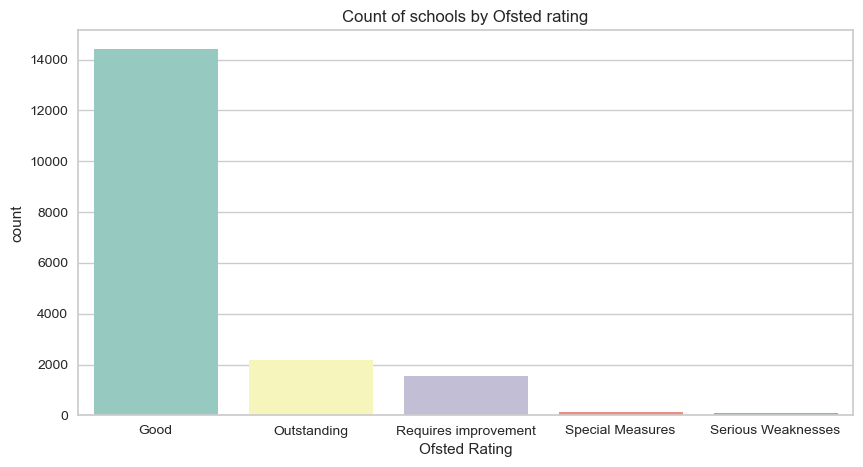

In [25]:
# explore distribution of school Ofsted rating
plt.figure(figsize=(10, 5))
sns.countplot(x='Ofsted Rating', data=schools, palette='Set3')
plt.title('Count of schools by Ofsted rating')
plt.show()

The Serious Weaknesses and Special Measures categories both fall into a 'category of concern' and result in schools being closely monitored (Ofsted, 2023). As there is a low school count for these categories and the implications are similar, these schools will be grouped under the heading 'Category of Concern' to make them easier to analyse. I will also transform them into a new ordinal variable to aid analysis. 

https://www.gov.uk/guidance/inspecting-schools-guide-for-maintained-and-academy-schools#:~:text=When%20we%20judge%20a%20school,or%20to%20require%20special%20measures.

In [26]:
# check values for ofsted rating
np.unique(schools['Ofsted Rating'])

array(['Good', 'Outstanding', 'Requires improvement',
       'Serious Weaknesses', 'Special Measures'], dtype=object)

In [27]:
# create a copy of Ofsted rating column for new Category of Concern label
schools['Ofsted New'] = schools['Ofsted Rating']

In [28]:
# replace labels in new column
schools['Ofsted New'].replace('Serious Weaknesses', 'Category of Concern', inplace=True)
schools['Ofsted New'].replace('Special Measures', 'Category of Concern', inplace=True)

In [29]:
# check values for ofsted new
np.unique(schools['Ofsted New'])

array(['Category of Concern', 'Good', 'Outstanding',
       'Requires improvement'], dtype=object)

In [30]:
# create a copy of Ofsted New column to create ordinal variable
schools['Ofsted Score'] = schools['Ofsted New']

In [31]:
# replace strings in new column with numbers so that values can be ordered and to aid visulisation
schools['Ofsted Score'].replace('Category of Concern', 1, inplace=True)
schools['Ofsted Score'].replace('Requires improvement', 2, inplace=True)
schools['Ofsted Score'].replace('Good', 3, inplace=True)
schools['Ofsted Score'].replace('Outstanding', 4, inplace=True)

schools.head()

,URN,School Name,Phase,Pupils on Roll,Ofsted Rating,RSC Region,Region Classification,Easting,Northing,FSM Rate,Funding per Pupil,Total Funding,Total Absence Rate,Ofsted New,Ofsted Score
0,101614,Downe Primary School,Primary,74,Good,South-East England and South London,(England/Wales) Rural hamlet and isolated dwel...,543350,161795,10.8,6441.80,510049.0,8.14970,Good,3
1,102028,Forty Hill CofE Primary School,Primary,227,Good,North-West London and South-Central England,(England/Wales) Rural hamlet and isolated dwel...,534178,198690,17.2,4958.39,1170602.0,4.98025,Good,3
2,105078,Thurstaston Dawpool CofE Primary School,Primary,219,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,324660,384721,2.8,4265.00,968304.0,6.27767,Outstanding,4
3,105344,"Holly Mount Roman Catholic Primary School, Bury",Primary,276,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,376989,414229,4.3,4296.65,1315619.0,4.72174,Outstanding,4
4,106270,St Damian's RC Science College,Secondary,837,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,395017,401424,18.4,6060.34,5422860.0,7.11089,Outstanding,4


In [32]:
# check values for ofsted score
np.unique(schools['Ofsted Score'])

array([1, 2, 3, 4])

#### Urban / Rural Classification

In [33]:
# explore regional classifications
schools.groupby('Region Classification').size()

Region Classification
(England/Wales) Rural hamlet and isolated dwellings                         736
(England/Wales) Rural hamlet and isolated dwellings in a sparse setting      78
(England/Wales) Rural town and fringe                                      1920
(England/Wales) Rural town and fringe in a sparse setting                   104
(England/Wales) Rural village                                              1980
(England/Wales) Rural village in a sparse setting                           144
(England/Wales) Urban city and town                                        7229
(England/Wales) Urban city and town in a sparse setting                      32
(England/Wales) Urban major conurbation                                    5586
(England/Wales) Urban minor conurbation                                     588
dtype: int64

Order of categories 
https://assets.publishing.service.gov.uk/media/610c08e4d3bf7f044024465a/RUCOA_leaflet_Jan2017.pdf

In [35]:
schools['RUC Score'] = schools['Region Classification']

In [36]:
schools['RUC Score'].replace('(England/Wales) Urban major conurbation', 10, inplace=True)
schools['RUC Score'].replace('(England/Wales) Urban minor conurbation', 9, inplace=True)
schools['RUC Score'].replace('(England/Wales) Urban city and town', 8, inplace=True)
schools['RUC Score'].replace('(England/Wales) Urban city and town in a sparse setting', 7, inplace=True)
schools['RUC Score'].replace('(England/Wales) Rural town and fringe', 6, inplace=True)
schools['RUC Score'].replace('(England/Wales) Rural village', 5, inplace=True)
schools['RUC Score'].replace('(England/Wales) Rural hamlet and isolated dwellings', 4, inplace=True)
schools['RUC Score'].replace('(England/Wales) Rural town and fringe in a sparse setting', 3, inplace=True)
schools['RUC Score'].replace('(England/Wales) Rural village in a sparse setting', 2, inplace=True)
schools['RUC Score'].replace('(England/Wales) Rural hamlet and isolated dwellings in a sparse setting', 1, inplace=True)
schools.groupby('RUC Score').size()

RUC Score
1       78
2      144
3      104
4      736
5     1980
6     1920
7       32
8     7229
9      588
10    5586
dtype: int64

In [37]:
schools['Urban/Rural'] = schools['Region Classification'].str[:21]
schools.head()

,URN,School Name,Phase,Pupils on Roll,Ofsted Rating,RSC Region,Region Classification,Easting,Northing,FSM Rate,Funding per Pupil,Total Funding,Total Absence Rate,Ofsted New,Ofsted Score,RUC Score,Urban/Rural
0,101614,Downe Primary School,Primary,74,Good,South-East England and South London,(England/Wales) Rural hamlet and isolated dwel...,543350,161795,10.8,6441.80,510049.0,8.14970,Good,3,4,(England/Wales) Rural
1,102028,Forty Hill CofE Primary School,Primary,227,Good,North-West London and South-Central England,(England/Wales) Rural hamlet and isolated dwel...,534178,198690,17.2,4958.39,1170602.0,4.98025,Good,3,4,(England/Wales) Rural
2,105078,Thurstaston Dawpool CofE Primary School,Primary,219,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,324660,384721,2.8,4265.00,968304.0,6.27767,Outstanding,4,4,(England/Wales) Rural
3,105344,"Holly Mount Roman Catholic Primary School, Bury",Primary,276,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,376989,414229,4.3,4296.65,1315619.0,4.72174,Outstanding,4,4,(England/Wales) Rural
4,106270,St Damian's RC Science College,Secondary,837,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,395017,401424,18.4,6060.34,5422860.0,7.11089,Outstanding,4,4,(England/Wales) Rural


In [38]:
schools['Urban/Rural'] = np.where(schools['Urban/Rural'] == '(England/Wales) Urban', 'Urban', 'Rural')
np.unique(schools['Urban/Rural'])

array(['Rural', 'Urban'], dtype=object)

In [39]:
# save the new dataframe to a csv file
schools.to_csv('schools_df.csv')

## Stage 2: Exploring the data

I am interested in understanding whether there are systematic differences in outcomes for pupils and schools according to their location and the level of funding allocated to them. Now that I have a dataframe containing all of the relevant information, I will explore how these variables of interest are related to each other. 

I am expecting to find:
- a relationship between school location (particularly, how far North a school is in England) and the level of funding it receives per pupil
- a relationship between how much funding a school receives per pupil and school and pupil outcomes (Ofsted rating and absence rate respectively)

### Categorical variables

#### School Phase
The exploration of funding allocation per pupil and total absence rates according to school phase, identified several outlier schools to be removed from the dataframe. These schools had extreme 'Total Absence Rates' linked with being small schools with well below the average number of 'Pupils on Roll' for their 'Phase'. 

#### RSC Region
The funding a school receives per pupil does appear to vary according to location within the country, however the available data suggests that the variation in funding within a region is far greater than the variation between regions. 

#### School Phase

In [107]:
# descriptive statistics for funding per pupil and absence rate grouped by school phase
schools.groupby('Phase')[['Funding per Pupil', 'Total Absence Rate']].describe()

Funding per Pupil                                              \
                        count         mean          std      min      25%   
Phase                                                                       
All-through             125.0  5932.218160   767.477723  4790.00  5369.34   
Primary               15415.0  5024.811870  1020.679108  4127.11  4383.79   
Secondary              2857.0  6178.393325   769.752065  4793.00  5638.71   

                                         Total Absence Rate            \
                 50%       75%       max              count      mean   
Phase                                                                   
All-through  5714.73  6436.270   9019.31              125.0  8.092358   
Primary      4752.52  5285.335  22225.33            15415.0  6.264158   
Secondary    5960.72  6484.680  11610.00             2857.0  8.745449   

                                                                        
                  std      min       25%      50%        75%       max  
Phase                                                                   
All-through  2.005762  4.09522  6.621590  8.05018   9.342090  15.16333  
Primary      1.565150  1.42075  5.311135  6.18780   7.095465  48.37762  
Secondary    2.348212  2.22638  7.250090  8.64506  10.017490  43.40578

The above descriptive statistics are largely in line with what I would expect: 
- the mean funding per pupil is lowest for primary schools and highest for secondary schools, which makes sense as the basic per-pupil funding is about £3,200 in primary schools, rises to £4,500 for pupils in in Key Stage 3 (ages 11–14) and £5,100 for pupils in Key Stage 4 (ages 14–16). 
- The mean absence rate is also highest for secondary schools, which may be partially explained by these students having greater autonomy over travelling to and from school and being able to stay home alone if their parents/carers need to go to work. 

However it is interesting to observe that the maximum values for both variable are considerably higher for primary schools. The funding per pupil for primary schools also has a far higher standard deviation, which suggests there is a broader spread of values. On the other hand, the standard deviation for primary absence rates is low, suggesting the high values for this condition represent anomalous or extreme rates for a small number of schools. This can be seen in the boxplots below - there are a several primary and secondary schools with extreme values for total absence rate. 

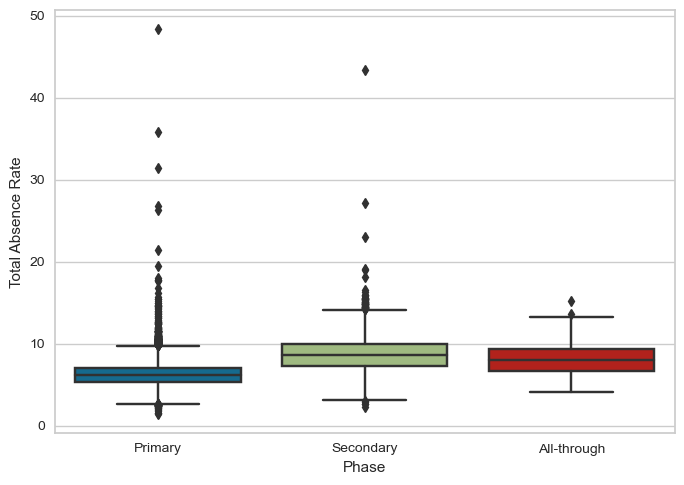

In [108]:
sns.boxplot(x='Phase', y='Total Absence Rate', data=schools);

In [109]:
# look at the records for schools with absence rates greater than 25%
schools.loc[schools['Total Absence Rate'] > 25]

,URN,School Name,Phase,Pupils on Roll,Ofsted Rating,RSC Region,Region Classification,Easting,Northing,FSM Rate,Funding per Pupil,Total Funding,Total Absence Rate,Ofsted New,Ofsted Score,RUC Score,Urban/Rural
58,111286,Huxley CofE Primary School,Primary,34,Special Measures,West Midlands,(England/Wales) Rural hamlet and isolated dwel...,351284,361354,8.8,8749.95,385762.0,48.37762,Category of Concern,1,4,Rural
595,142276,Hollinsclough Church of England Academy,Primary,30,Good,West Midlands,(England/Wales) Rural hamlet and isolated dwel...,406516,366551,25.9,7374.61,408771.0,31.37413,Good,3,4,Rural
3097,112807,Castleton CofE Primary School,Primary,22,Good,East Midlands and the Humber,(England/Wales) Rural village,415075,382971,18.2,9687.62,276746.0,26.75887,Good,3,5,Rural
3119,112858,Stoney Middleton CofE (C) Primary School,Primary,11,Good,East Midlands and the Humber,(England/Wales) Rural village,422881,375420,45.5,15236.64,241743.0,26.32637,Good,3,5,Rural
9198,137317,Stephenson Studio School,Secondary,79,Requires improvement,East Midlands and the Humber,(England/Wales) Urban city and town,442182,315340,43.0,10662.88,957593.0,27.18099,Requires improvement,2,8,Urban
11244,144007,Windsor Park CE Middle School,Secondary,368,Good,West Midlands,(England/Wales) Urban city and town,408526,333745,13.9,4793.00,1955240.0,43.40578,Good,3,8,Urban
11738,145772,Crays Hill Primary School,Primary,99,Good,East of England and North-East London,(England/Wales) Urban city and town,571911,192684,87.9,7298.06,869796.0,35.86042,Good,3,8,Urban


Looking at the records above, it seems as though the schools with extreme absence rates are very small, with low number of pupils on roll. 

To explore this further, I have run the below code to check the mean number of pupils on roll for Primary and Secondary schools. 

In [110]:
# get the mean number of pupils on roll for Primary and Secondary schools
print(schools.loc[schools['Phase'] == 'Primary', 'Pupils on Roll'].mean(), 
      schools.loc[schools['Phase'] == 'Secondary', 'Pupils on Roll'].mean())

276.1290301654233 1074.9362968148407


This confirms that the numbers on roll for the schools above are well below the average, and this is likely to skew the absence rates as a small number of absences will have a big impact to the overall rate. 

As a result, I am going to drop these records from the dataframe to avoid them skewing any results. 

In [111]:
# drop schools with absence rates above 25%
schools = schools.loc[schools['Total Absence Rate'] <= 25]
schools.groupby('Phase')[['Funding per Pupil', 'Total Absence Rate']].describe()

Funding per Pupil                                               \
                        count         mean          std      min       25%   
Phase                                                                        
All-through             125.0  5932.218160   767.477723  4790.00  5369.340   
Primary               15410.0  5023.304873  1016.045676  4127.11  4383.635   
Secondary              2855.0  6177.307828   764.992362  4793.00  5638.790   

                                          Total Absence Rate            \
                  50%       75%       max              count      mean   
Phase                                                                    
All-through  5714.730  6436.270   9019.31              125.0  8.092358   
Primary      4752.275  5284.895  22225.33            15410.0  6.255243   
Secondary    5960.720  6484.495  11610.00             2855.0  8.726851   

                                                                         
                  std      min       25%       50%        75%       max  
Phase                                                                    
All-through  2.005762  4.09522  6.621590  8.050180   9.342090  15.16333  
Primary      1.477893  1.42075  5.310742  6.187745   7.094485  21.38447  
Secondary    2.231054  2.22638  7.249840  8.642580  10.014945  22.97348

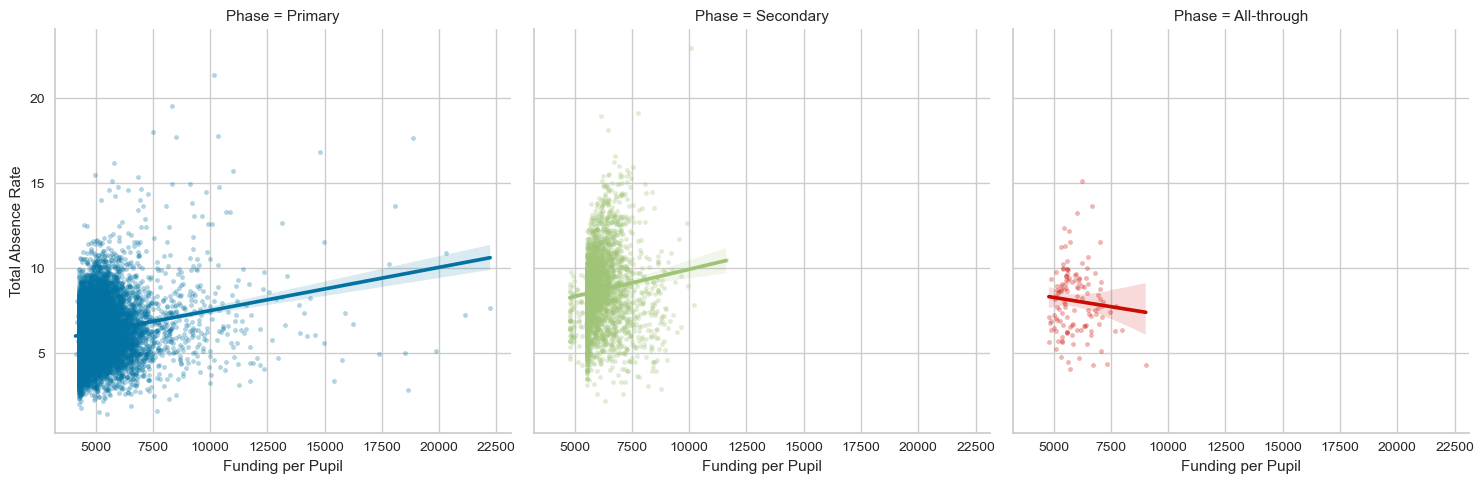

In [112]:
# scatterplot with regression line to see how this has changed the distribution of the data
sns.lmplot(x='Funding per Pupil', y='Total Absence Rate',  hue='Phase',
               col='Phase', data=schools, markers='.', scatter_kws={'alpha':0.3});

#### Regional School Commissioner (RSC) Regions

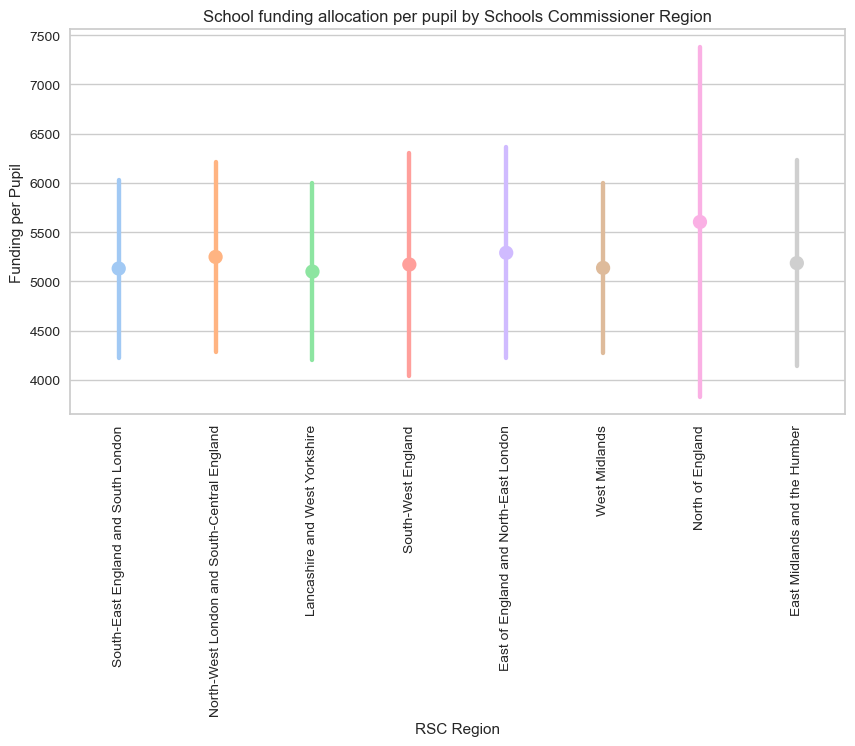

In [40]:
plt.figure(figsize=(10, 5))
sns.pointplot(x='RSC Region', y='Funding per Pupil', data=schools, ci="sd", palette="pastel")
plt.title('School funding allocation per pupil by Schools Commissioner Region')
plt.xticks(rotation=90)

plt.show()

The North of England has the greatest spread of values, with both the highest and lowest funding allocation per pupil. Overall, this region actually has the highest funded schools on average. 

The lowest average funding per pupil is in South-East England and South London, Lancashire and West Yorkshire, and the West Midlands. 

In [153]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18390 entries, 0 to 18397
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   URN                    18390 non-null  int64  
 1   School Name            18390 non-null  object 
 2   Phase                  18390 non-null  object 
 3   Pupils on Roll         18390 non-null  int64  
 4   Ofsted Rating          18390 non-null  object 
 5   RSC Region             18390 non-null  object 
 6   Region Classification  18390 non-null  object 
 7   Easting                18390 non-null  int64  
 8   Northing               18390 non-null  int64  
 9   FSM Rate               18390 non-null  float64
 10  Funding per Pupil      18390 non-null  float64
 11  Total Funding          18390 non-null  float64
 12  Total Absence Rate     18390 non-null  float64
 13  Ofsted New             18390 non-null  object 
 14  Ofsted Score           18390 non-null  int64  
 15  RUC Sco

### Numerical variables

#### Variable Distribution

In [41]:
# dataframe for continuous variables to check distribution
cont_vars = schools.iloc[:,[3, 7, 8, 9, 10, 12]]

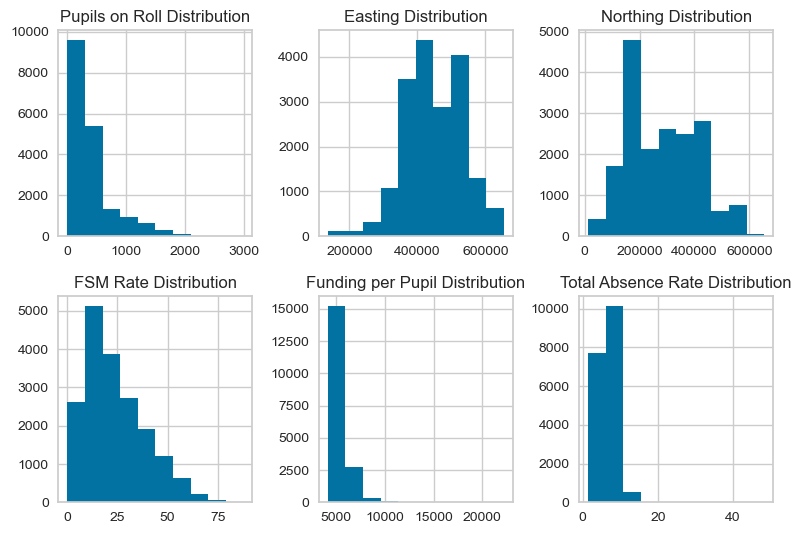

In [42]:
# check distribution of variables
def draw_histograms(df, variables, n_rows, n_cols):
    fig = plt.figure()
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name + ' Distribution')
    fig.tight_layout() 
    plt.show()

draw_histograms(cont_vars, cont_vars.columns, 2, 3)

#### Relationships between variables of interest

In [43]:
# create a dataframe with the numeric variables of interest 
numeric_vars = schools.iloc[:,[3, 7, 8, 9, 10, 11, 12, 14, 15]]
numeric_vars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18397 entries, 0 to 18397
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pupils on Roll      18397 non-null  int64  
 1   Easting             18397 non-null  int64  
 2   Northing            18397 non-null  int64  
 3   FSM Rate            18397 non-null  float64
 4   Funding per Pupil   18397 non-null  float64
 5   Total Funding       18397 non-null  float64
 6   Total Absence Rate  18397 non-null  float64
 7   Ofsted Score        18397 non-null  int64  
 8   RUC Score           18397 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 1.4 MB


In [44]:
# descriptive statistics 
numeric_vars.describe()

,Pupils on Roll,Easting,Northing,FSM Rate,Funding per Pupil,Total Funding,Total Absence Rate,Ofsted Score,RUC Score
count,18397.000000,18397.000000,18397.000000,18397.000000,18397.000000,1.839700e+04,18397.000000,18397.000000,18397.000000
mean,407.854378,449510.833179,283098.250204,23.793004,5210.125127,2.224772e+06,6.661917,3.007990,7.840952
std,370.945045,85777.519524,128039.552958,14.868058,1070.885708,2.147521e+06,1.938159,0.503404,1.969829
min,0.000000,136274.000000,12574.000000,0.000000,4127.110000,2.147650e+05,1.420750,1.000000,1.000000
25%,188.000000,389649.000000,177567.000000,12.100000,4434.170000,9.569810e+05,5.448810,3.000000,6.000000
50%,278.000000,443490.000000,275118.000000,20.300000,4935.500000,1.433329e+06,6.402780,3.000000,8.000000
75%,457.000000,519644.000000,392627.000000,33.000000,5628.350000,2.382161e+06,7.570760,3.000000,10.000000
max,2990.000000,654588.000000,654722.000000,87.900000,22225.330000,1.770485e+07,48.377620,4.000000,10.000000


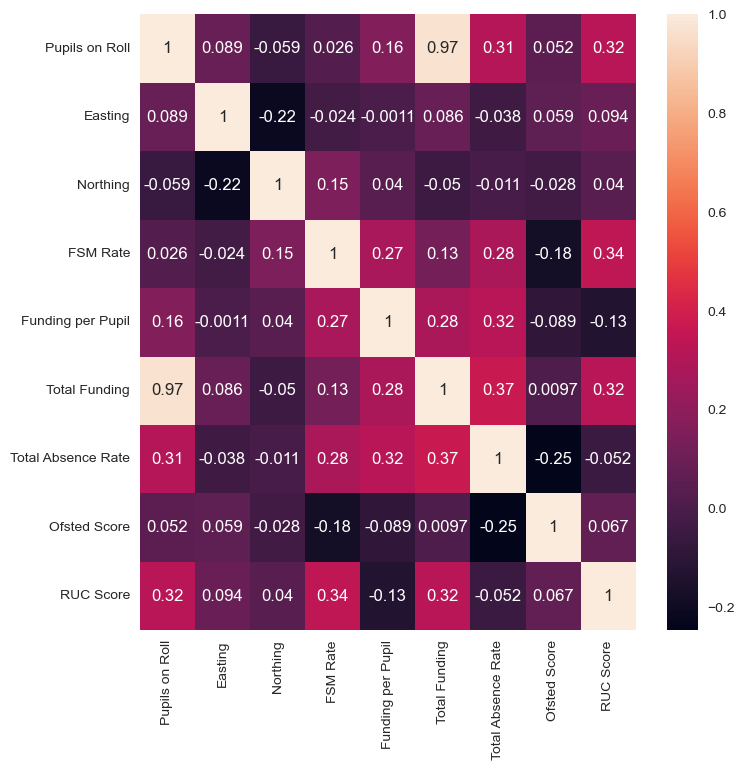

In [45]:
# plot correlation matrix as heatmap to view results more clearly
plt.figure(figsize=(8,8))    # set figure size
sns.heatmap(numeric_vars.corr(), annot = True);  # annot = True annotates the cells with the correlation value

The above correlation matrix shows that the total funding allocated per school is very strongly correlated with the number of pupils on roll, which is exactly what I would expect.  

#### School funding, Ofsted ratings and absences
An interesting finding is the negative correlation between Ofsted rating and school absences, which means that higher performing schools in this data set tend to have lower absence rates, which makes sense. 

Whilst there does not appear to be any relationship between the funding a school receives and its Ofsted rating, there is a positive correlation between the funding a school receives (both overall and calculated as a per pupil rate) and the overall absence rate. This may be due to the funding formula that means schools receive additional funding for pupils with characteristics that make it more difficult to engage with school. Indeed, the matrix shows a small positive correlation between the proportion of pupils eligible for free school meals and the overall school absence rate. This finding is in line with research that has shown a more deprived background can act as a barrier to engagement with education (REFERENCE). 

The correlation between school funding and overall absence rate could suggest that funding is being prioritised towards the right schools, on the basis of these additional challenges, but it may also suggest that this strategy is having limited impact in terms of overcoming barriers to engagement. 


#### School location
According to this data, there seems to be no relationship between the Northing coordinate of the school and any of the other variables in the matrix. There is, however a positive correlation between Rural/Urban Classification Score and the total funding, FSM rate and pupils on roll. This indicates that schools in more densly populated areas, have more pupils on roll and a higher proportion who are eligible for FSM. Both of these factors are directly related to how much funding a school receives. 

## Stage 3: Unsupervised machine learning

As there was no observable relationship between schools' northing coordinates and the other variables of interest, the next step is to use unsupervised machine learning techniques to see whether this can identify any meaningful or useful patterns in the data.

#### Data preparation steps:

- I will exclude Total Funding as it was highly correlated with Pupils on Roll and there is a more appropriate measure of funding in the form of Funding per Pupil.
- I will use sklearn's preprocessing OrdinalEncoder and OneHotEncoder to transform the categorical variables and ordinal variable (Ofsted rating) into numeric variables
- I will use another sklearn transformer, PowerTransformer, on the continuous variables to increase the normality of the distribution
- KMeans clustering is very sensitive to anomolies and so I will use ECOD (empirical cumulative distribution functions for outlier detection) to identify any outliers for removal. 

#### Data Transformation

In [46]:
# transformer to covert categorical variables 
cat_transformer_onehot = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', 
                                                                            sparse=False))])

# set order of values for ordinal variable
cat_transformer_ordinal = Pipeline(steps=[('encoder',
                                                  OrdinalEncoder(categories=[['Outstanding', 'Good', 
                                                                       'Requires improvement',
                                                                       'Serious Weaknesses',
                                                                       'Special Measures']]))])

# transformer to move towards normal distribution of numerical variables
num = Pipeline(steps=[('encoder', PowerTransformer())])      

In [47]:
# classify columns for transformation
preprocessor  = ColumnTransformer(transformers = [
    ('cat_onehot', cat_transformer_onehot, 
     ['Phase', 'RSC Region', 'Urban/Rural']), 
    ('cat_ordinal', cat_transformer_ordinal,
     ['Ofsted Rating']),
    ('num', num,
     ['Pupils on Roll', 'Easting', 'Northing','FSM Rate', 
      'Funding per Pupil', 'Total Absence Rate'])
])

In [48]:
# transform the data
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])
pipe_fit = pipeline.fit(schools)

df_num = pd.DataFrame(pipe_fit.transform(schools), columns = pipe_fit.get_feature_names_out().tolist())
df_num

,cat_onehot__Phase_All-through,cat_onehot__Phase_Primary,cat_onehot__Phase_Secondary,cat_onehot__RSC Region_East Midlands and the Humber,cat_onehot__RSC Region_East of England and North-East London,cat_onehot__RSC Region_Lancashire and West Yorkshire,cat_onehot__RSC Region_North of England,cat_onehot__RSC Region_North-West London and South-Central England,cat_onehot__RSC Region_South-East England and South London,cat_onehot__RSC Region_South-West England,cat_onehot__RSC Region_West Midlands,cat_onehot__Urban/Rural_Rural,cat_onehot__Urban/Rural_Urban,cat_ordinal__Ofsted Rating,num__Pupils on Roll,num__Easting,num__Northing,num__FSM Rate,num__Funding per Pupil,num__Total Absence Rate
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-1.592811,1.108793,-0.931232,-0.866433,1.591560e-12,0.882349
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.315184,0.994297,-0.584922,-0.271111,2.287059e-14,-0.931784
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.357407,-1.431359,0.827582,-2.081525,-1.622424e-12,-0.074860
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.083651,-0.862625,1.019026,-1.769516,-1.523226e-12,-1.129353
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.279295,-0.660521,0.936751,-0.176145,1.326994e-12,0.383910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18392,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.155543,-0.077326,0.527119,1.187326,-4.155010e-13,0.048455
18393,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.429224,-0.128266,0.589763,0.272573,-1.178502e-12,-0.618840
18394,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.159113,-0.090109,0.818465,-0.320193,-1.622424e-12,-0.420482
18395,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.448253,0.083778,0.502038,-1.788297,-1.622424e-12,-0.809450


In [49]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18397 entries, 0 to 18396
Data columns (total 20 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   cat_onehot__Phase_All-through                                       18397 non-null  float64
 1   cat_onehot__Phase_Primary                                           18397 non-null  float64
 2   cat_onehot__Phase_Secondary                                         18397 non-null  float64
 3   cat_onehot__RSC Region_East Midlands and the Humber                 18397 non-null  float64
 4   cat_onehot__RSC Region_East of England and North-East London        18397 non-null  float64
 5   cat_onehot__RSC Region_Lancashire and West Yorkshire                18397 non-null  float64
 6   cat_onehot__RSC Region_North of England                             18397 non-null  float64
 7   cat_onehot__R

In [50]:
# create a df containing the transformed continuous variables to compare to previous distributions
cont_vars_transformed = df_num.iloc[:,[14, 15, 16, 17, 18, 19]]

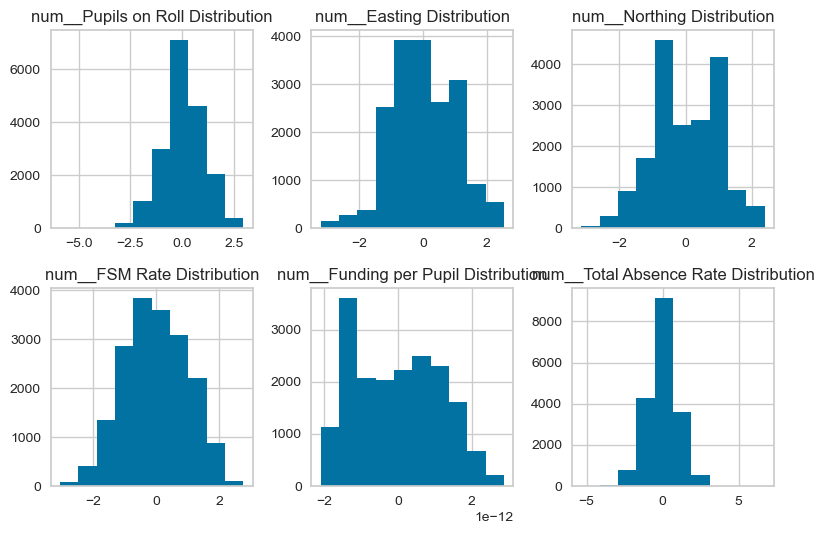

In [51]:
# plot distribution of transformed continuous varibles to confirm improved normality
draw_histograms(cont_vars_transformed, cont_vars_transformed.columns, 2, 3)

#### Check for and remove anomolies

In [54]:
clf = ECOD()
clf.fit(df_num)
outliers = clf.predict(df_num)

df_num['Outliers'] = outliers
df_num.head()

,cat_onehot__Phase_All-through,cat_onehot__Phase_Primary,cat_onehot__Phase_Secondary,cat_onehot__RSC Region_East Midlands and the Humber,cat_onehot__RSC Region_East of England and North-East London,cat_onehot__RSC Region_Lancashire and West Yorkshire,cat_onehot__RSC Region_North of England,cat_onehot__RSC Region_North-West London and South-Central England,cat_onehot__RSC Region_South-East England and South London,cat_onehot__RSC Region_South-West England,...,cat_onehot__Urban/Rural_Rural,cat_onehot__Urban/Rural_Urban,cat_ordinal__Ofsted Rating,num__Pupils on Roll,num__Easting,num__Northing,num__FSM Rate,num__Funding per Pupil,num__Total Absence Rate,Outliers
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,-1.592811,1.108793,-0.931232,-0.866433,1.591560e-12,0.882349,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,-0.315184,0.994297,-0.584922,-0.271111,2.287059e-14,-0.931784,0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-0.357407,-1.431359,0.827582,-2.081525,-1.622424e-12,-0.074860,0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-0.083651,-0.862625,1.019026,-1.769516,-1.523226e-12,-1.129353,0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.279295,-0.660521,0.936751,-0.176145,1.326994e-12,0.383910,0


In [62]:
# count outliers detected
df_num.groupby('Outliers').size()

Outliers
0    16557
1     1840
dtype: int64

In [94]:
# create new dataframe with outliers removed
df_clean = df_num.copy()
df_clean = df_clean[df_clean['Outliers'] == 0]
df_clean = df_clean.drop(['Outliers'], axis = 1)

# check correct number of records remain, and column removed
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16557 entries, 0 to 18396
Data columns (total 20 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   cat_onehot__Phase_All-through                                       16557 non-null  float64
 1   cat_onehot__Phase_Primary                                           16557 non-null  float64
 2   cat_onehot__Phase_Secondary                                         16557 non-null  float64
 3   cat_onehot__RSC Region_East Midlands and the Humber                 16557 non-null  float64
 4   cat_onehot__RSC Region_East of England and North-East London        16557 non-null  float64
 5   cat_onehot__RSC Region_Lancashire and West Yorkshire                16557 non-null  float64
 6   cat_onehot__RSC Region_North of England                             16557 non-null  float64
 7   cat_onehot__RSC Re

### Clustering approach 1: Raw data

In [95]:
# create a new instance of k-means class with 4 clusters
estimator = KMeans(init='random', n_clusters=4, n_init=10, max_iter=300, random_state=42)
estimator

KMeans(init='random', n_clusters=4, n_init=10, random_state=42)

In [96]:
# fit the data to the estimator
X = df_clean
estimator.fit(X)

KMeans(init='random', n_clusters=4, n_init=10, random_state=42)

In [97]:
# get cluster labels assigned to each data point
estimator.labels_

array([2, 2, 1, ..., 1, 1, 0], dtype=int32)

In [98]:
# check all datapoints have been assigned to a cluster
len(estimator.labels_) == len(X)

True

In [99]:
# final cluster centroid locations (4 clusters x 7 variables)
estimator.cluster_centers_

array([[ 4.51467269e-04,  9.94356659e-01,  5.19187359e-03,
         2.18961625e-01,  3.83747178e-03,  3.56207675e-01,
         1.42212190e-01,  6.54627540e-03,  6.77200903e-04,
         5.71106095e-02,  2.14446953e-01,  6.95259594e-02,
         9.30474041e-01,  1.06704289e+00, -6.37809980e-02,
        -5.12685230e-01,  7.51954084e-01,  9.11655448e-01,
        -5.27778598e-14,  1.12723479e-01],
       [ 2.16637782e-04,  9.98483536e-01,  1.29982669e-03,
         1.91507799e-01,  4.76603120e-03,  1.89558059e-01,
         9.14211438e-02,  9.09878683e-02,  1.97140381e-02,
         2.29852686e-01,  1.82192374e-01,  5.17114385e-01,
         4.82885615e-01,  9.34792028e-01, -5.64057254e-01,
        -5.54948855e-01,  1.86533846e-01, -8.05222155e-01,
        -5.88276058e-13, -5.20443021e-01],
       [ 1.77053824e-04,  9.89553824e-01,  1.02691218e-02,
         7.79036827e-03,  2.86473088e-01,  0.00000000e+00,
        -8.18789481e-16,  2.89483003e-01,  4.00849858e-01,
         1.54036827e-02,  4.1

In [100]:
# the number of iterations required to converge
estimator.n_iter_

9

In [101]:
# save cluster allocation output
k4_raw = pd.Series(estimator.labels_, index=X.index)
k4_raw.head()

0    2
1    2
2    1
3    1
4    3
dtype: int32

### Clustering approach 2: Re-scaled data

In [102]:
# re-scale the variables of interest so they are standardised to values between 0 and 1
scaler = MinMaxScaler()

scaled_df = pd.DataFrame(scaler.fit_transform(df_clean.values), 
                      columns=df_clean.columns, index=df_clean.index)

scaled_df.describe()

,cat_onehot__Phase_All-through,cat_onehot__Phase_Primary,cat_onehot__Phase_Secondary,cat_onehot__RSC Region_East Midlands and the Humber,cat_onehot__RSC Region_East of England and North-East London,cat_onehot__RSC Region_Lancashire and West Yorkshire,cat_onehot__RSC Region_North of England,cat_onehot__RSC Region_North-West London and South-Central England,cat_onehot__RSC Region_South-East England and South London,cat_onehot__RSC Region_South-West England,cat_onehot__RSC Region_West Midlands,cat_onehot__Urban/Rural_Rural,cat_onehot__Urban/Rural_Urban,cat_ordinal__Ofsted Rating,num__Pupils on Roll,num__Easting,num__Northing,num__FSM Rate,num__Funding per Pupil,num__Total Absence Rate
count,16557.000000,16557.000000,16557.000000,16557.000000,16557.000000,16557.000000,16557.000000,16557.000000,16557.000000,16557.000000,16557.000000,16557.000000,16557.000000,16557.000000,16557.000000,16557.000000,16557.000000,16557.000000,16557.000000,16557.000000
mean,0.001087,0.883675,0.115238,0.130881,0.110044,0.165549,0.067404,0.146947,0.158604,0.092891,0.127680,0.246059,0.753941,0.243719,0.530275,0.546907,0.524410,0.544773,0.370224,0.608644
std,0.032955,0.320624,0.319319,0.337281,0.312954,0.371687,0.250727,0.354064,0.365317,0.290289,0.333743,0.430726,0.430726,0.118465,0.159224,0.170014,0.189420,0.173916,0.246931,0.102658
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.250000,0.440525,0.414646,0.369178,0.415836,0.127365,0.546512
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.250000,0.513262,0.526375,0.533104,0.537346,0.357031,0.612226
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.250000,0.620889,0.687262,0.696129,0.675601,0.584543,0.675519
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [103]:
# create a new instance of k-means class with 4 clusters
estimator = KMeans(init='random', n_clusters=4, n_init=10, max_iter=300, random_state=42)
estimator

KMeans(init='random', n_clusters=4, n_init=10, random_state=42)

In [104]:
# fit the data to the estimator
X = scaled_df
estimator.fit(X)

KMeans(init='random', n_clusters=4, n_init=10, random_state=42)

In [105]:
# save cluster allocation output
k4_scaled = pd.Series(estimator.labels_, index=X.index)
k4_scaled.head()

0    1
1    1
2    1
3    1
4    3
dtype: int32

### Clustering approach 3: Principle Component Analysis (PCA)

For the visualisations, PCA can be used to reduce dimensionality. Before I apply PCA the data needs to be centred but not scaled. 

In [106]:
centred_df = df_clean.apply(lambda x: x-x.mean())
centred_df

,cat_onehot__Phase_All-through,cat_onehot__Phase_Primary,cat_onehot__Phase_Secondary,cat_onehot__RSC Region_East Midlands and the Humber,cat_onehot__RSC Region_East of England and North-East London,cat_onehot__RSC Region_Lancashire and West Yorkshire,cat_onehot__RSC Region_North of England,cat_onehot__RSC Region_North-West London and South-Central England,cat_onehot__RSC Region_South-East England and South London,cat_onehot__RSC Region_South-West England,cat_onehot__RSC Region_West Midlands,cat_onehot__Urban/Rural_Rural,cat_onehot__Urban/Rural_Urban,cat_ordinal__Ofsted Rating,num__Pupils on Roll,num__Easting,num__Northing,num__FSM Rate,num__Funding per Pupil,num__Total Absence Rate
0,-0.001087,0.116325,-0.115238,-0.130881,-0.110044,-0.165549,-0.067404,-0.146947,0.841396,-0.092891,-0.12768,0.753941,-0.753941,0.025125,-1.571504,1.066059,-0.942922,-0.867066,1.737705e-12,0.967424
1,-0.001087,0.116325,-0.115238,-0.130881,-0.110044,-0.165549,-0.067404,0.853053,-0.158604,-0.092891,-0.12768,0.753941,-0.753941,0.025125,-0.293877,0.951563,-0.596612,-0.271745,1.690153e-13,-0.846708
2,-0.001087,0.116325,-0.115238,-0.130881,-0.110044,0.834451,-0.067404,-0.146947,-0.158604,-0.092891,-0.12768,0.753941,-0.753941,-0.974875,-0.336100,-1.474093,0.815892,-2.082158,-1.476280e-12,0.010216
3,-0.001087,0.116325,-0.115238,-0.130881,-0.110044,0.834451,-0.067404,-0.146947,-0.158604,-0.092891,-0.12768,0.753941,-0.753941,-0.974875,-0.062343,-0.905359,1.007336,-1.770150,-1.377081e-12,-1.044277
4,-0.001087,-0.883675,0.884762,-0.130881,-0.110044,0.834451,-0.067404,-0.146947,-0.158604,-0.092891,-0.12768,0.753941,-0.753941,-0.974875,1.300602,-0.703255,0.925061,-0.176778,1.473139e-12,0.468985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18392,-0.001087,0.116325,-0.115238,0.869119,-0.110044,-0.165549,-0.067404,-0.146947,-0.158604,-0.092891,-0.12768,-0.246059,0.246059,0.025125,0.176850,-0.120060,0.515430,1.186692,-2.693563e-13,0.133531
18393,-0.001087,0.116325,-0.115238,0.869119,-0.110044,-0.165549,-0.067404,-0.146947,-0.158604,-0.092891,-0.12768,-0.246059,0.246059,0.025125,-0.407917,-0.171000,0.578074,0.271940,-1.032357e-12,-0.533764
18394,-0.001087,0.116325,-0.115238,0.869119,-0.110044,-0.165549,-0.067404,-0.146947,-0.158604,-0.092891,-0.12768,-0.246059,0.246059,0.025125,0.180420,-0.132842,0.806775,-0.320826,-1.476280e-12,-0.335407
18395,-0.001087,0.116325,-0.115238,0.869119,-0.110044,-0.165549,-0.067404,-0.146947,-0.158604,-0.092891,-0.12768,-0.246059,0.246059,0.025125,0.469560,0.041044,0.490348,-1.788931,-1.476280e-12,-0.724374


In [107]:
# reduce the 8 features down to the 2 with the most variance (principle component analysis)
pca_estimator = PCA(n_components=2)
pca_estimator

PCA(n_components=2)

In [108]:
# fit the data to the model and transform in a single step
X = centred_df
components = pca_estimator.fit_transform(X)
components

array([[ 1.73935715, -0.04591001],
       [ 1.46053619,  0.13233181],
       [ 0.19835844,  2.26351636],
       ...,
       [-0.32757244,  0.53725937],
       [ 0.78907225,  0.88210368],
       [-1.72561289, -0.37156518]])

In [109]:
# save as dataframe
components = pd.DataFrame(components, index=df_clean.index, columns = ['C1', 'C2'])
components.head()

,C1,C2
0,1.739357,-0.045910
1,1.460536,0.132332
2,0.198358,2.263516
3,0.458267,2.282858
4,-1.089299,0.053303


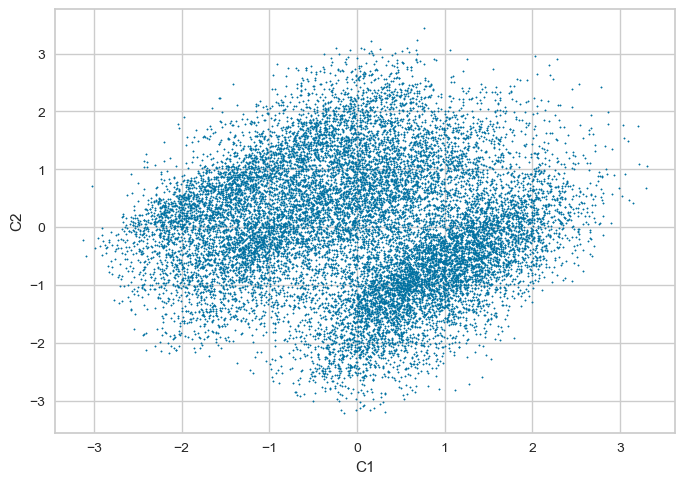

In [110]:
components.plot.scatter('C1', 'C2', s=1);

In [111]:
estimator = KMeans(init='random', n_clusters=4, n_init=10, max_iter=300, random_state=42)
estimator.fit(components)
k4_pca = pd.Series(estimator.labels_, index=components.index)
k4_pca.head()

0    1
1    1
2    2
3    2
4    3
dtype: int32

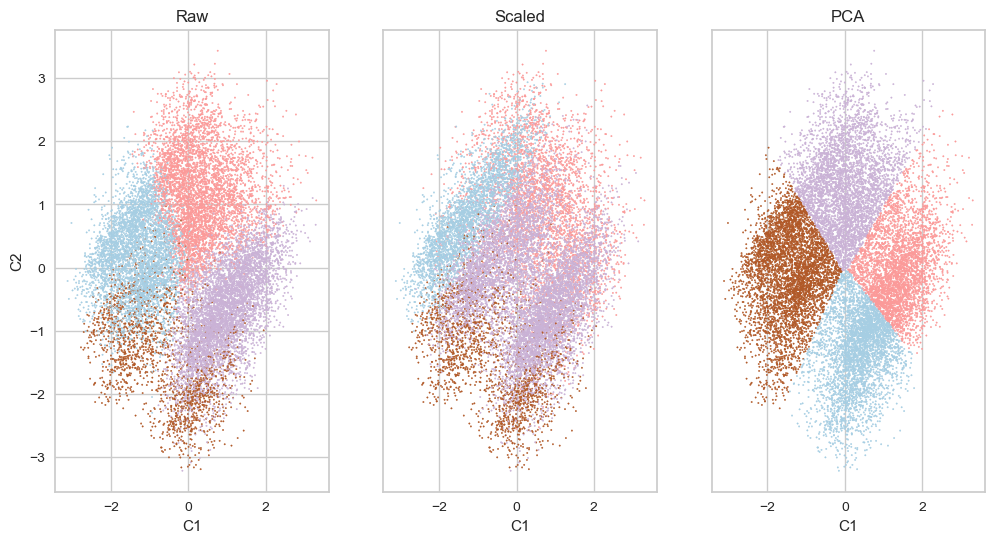

In [112]:
f, axs = plt.subplots(1, 3, figsize=(12, 6))

ax = axs[0]
components.assign(labels=k4_raw).plot.scatter('C1', 'C2', c='labels', s=1,
                        cmap='Paired', colorbar=False, ax=ax)
ax.set_title('Raw')


ax = axs[1]
components.assign(labels=k4_scaled).plot.scatter('C1', 'C2', c='labels', s=1,
                        cmap='Paired', colorbar=False, ax=ax)
ax.set_title('Scaled')
ax.yaxis.set_visible(False)


ax = axs[2]
components.assign(labels=k4_pca).plot.scatter('C1', 'C2', c='labels', s=1,
                        cmap='Paired', colorbar=False, ax=ax)
ax.set_title("PCA")
ax.yaxis.set_visible(False)

plt.show()

In [113]:
# Compute the Calinski and Harabasz score: sum of between-cluster dispersion and of within-cluster dispersion
chs_raw = calinski_harabasz_score(df_clean, k4_raw)
chs_scaled = calinski_harabasz_score(df_clean, k4_scaled)
chs_PCA = calinski_harabasz_score(df_clean, k4_pca)

pd.Series({'Raw:': chs_raw, 'Scaled': chs_scaled, 'PCA': chs_PCA})

Raw:      3013.070745
Scaled    2292.277519
PCA       2654.701277
dtype: float64

The Calinski and Harabasz scores above suggest that the clustering on the raw data or the PCA are superior, in that they maximise the between group dispersion and minimise the within group dispersion. 

In [114]:
# iterate through the model using increments of k and record the sum of the squared error (SSE) for each
kmeans_kwargs = {'init': 'random', 'n_init': 10, 'max_iter': 300, 'random_state': 42}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_clean)
    sse.append(kmeans.inertia_)

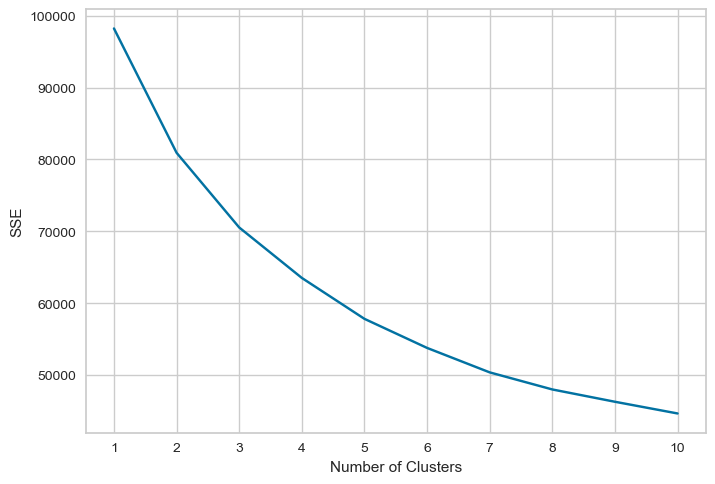

In [115]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

There is not an easily identifiable 'elbow' in the plot above, however the line is fairly flat after 5 clusters, suggesting this could be the optimal. 

In [116]:
estimator = KMeans(init='random', n_clusters=5, n_init=10, max_iter=300, random_state=42)
X = df_clean
estimator.fit(X)

KMeans(init='random', n_clusters=5, n_init=10, random_state=42)

In [117]:
k5_raw = pd.Series(estimator.labels_, index=X.index)
k5_raw.head()

0    1
1    1
2    0
3    0
4    4
dtype: int32

In [118]:
chs_k5_raw = calinski_harabasz_score(df_clean, k5_raw)
chs_k5_raw

2889.2730858995324

In [119]:
g = df_clean.groupby(k5_raw)
g

In [120]:
g.size()\
 .sort_values()

2    1578
4    1843
0    3618
3    3862
1    5656
dtype: int64

In [121]:
g.mean()

,cat_onehot__Phase_All-through,cat_onehot__Phase_Primary,cat_onehot__Phase_Secondary,cat_onehot__RSC Region_East Midlands and the Humber,cat_onehot__RSC Region_East of England and North-East London,cat_onehot__RSC Region_Lancashire and West Yorkshire,cat_onehot__RSC Region_North of England,cat_onehot__RSC Region_North-West London and South-Central England,cat_onehot__RSC Region_South-East England and South London,cat_onehot__RSC Region_South-West England,cat_onehot__RSC Region_West Midlands,cat_onehot__Urban/Rural_Rural,cat_onehot__Urban/Rural_Urban,cat_ordinal__Ofsted Rating,num__Pupils on Roll,num__Easting,num__Northing,num__FSM Rate,num__Funding per Pupil,num__Total Absence Rate
0,0.000276,0.997236,0.002488,0.270868,0.003593,0.281371,0.142344,0.066611,0.003870,0.008845,0.222499,0.454395,0.545605,0.907960,-0.494318,-0.405397,0.737806,-0.788418,-6.502186e-13,-0.666438
1,0.000177,0.990276,0.009547,0.006365,0.286775,0.000000,0.000000,0.311528,0.395332,0.000000,0.000000,0.215877,0.784123,0.933876,-0.070997,0.983082,-0.680994,-0.081845,-2.940508e-13,-0.220210
2,0.000000,0.992395,0.007605,0.000000,0.000000,0.000000,0.000000,0.036122,0.064005,0.861217,0.038657,0.486058,0.513942,1.036755,-0.521651,-1.070424,-1.168906,-0.296593,-4.341251e-13,0.061945
3,0.000518,0.992750,0.006732,0.228638,0.005697,0.372864,0.139306,0.006214,0.000777,0.007250,0.239254,0.061367,0.938633,1.075350,-0.044820,-0.468035,0.836739,0.995214,1.538790e-14,0.140347
4,0.007596,0.011937,0.980467,0.145415,0.089528,0.153554,0.034183,0.189365,0.147585,0.064569,0.175800,0.111232,0.888768,0.968530,1.537424,0.060032,-0.006016,-0.026907,1.205397e-12,0.872660


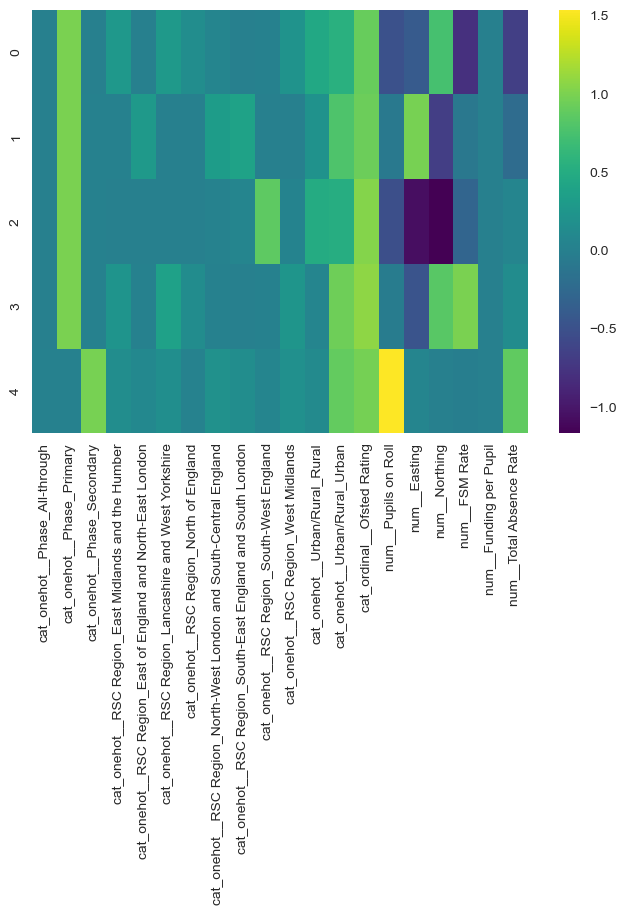

In [122]:
sns.heatmap(g.mean(), cmap='viridis');

all through schools distributed across all clusters. Primary distributed across clusters 0-4 and secondary schools predominently in cluster 5, which is also characterised by the highest numbers of pupils on roll, highest total funding (these two variables are highly correlated). 

Higher numbers of northern schools are in clusters 0 and 5, hihger numbers of eastern schools are in cluster 2, whilst schools in the South West region of england are higher in cluster 1. 